
<br>
Train a deep surrogate model to approximate the parametric solution of the Fin equation <br>
u''(x) + u'(x)/x - Bi(x)u(x) = 0 <br>
over a domain where Bi(x) is represented by a polynomial of degree up to 15 with <br>
coefficients lying within a suitable domain<br>


In [1]:
%tensorflow_version 1.x
import tensorflow
print(tensorflow.__version__)
import tensorflow as tf

TensorFlow 1.x selected.
1.15.2


In [4]:
import numpy as np
from matplotlib import pyplot as plt
import sys
import importlib

In [ ]:
from httpimport import github_repo
with github_repo('tonyshardlow', 'deep_surrogate', 'dense_net'):
    import dense_net
from dense_net import *

In [5]:
np.random.seed(0)
tf.set_random_seed(0)

In [6]:
def train(iterations,learning_rate): # main training loop
    for i in np.arange(iterations):
        xl = sample_xl(xlim,sizel)
        xr = sample_xr(xlim,sizer)
        x = sample_x(xlim,sizex)
        coeff, coeffl, coeffr = sample_coeff(coefflim,sizex,sizel)
        tf_dict = {lr:learning_rate , xl_pl:xl , x_pl:x , xr_pl:xr , \
                   coeffl_pl:coeffl, coeff_pl:coeff, coeffr_pl:coeffr}
        sess.run(train_op,tf_dict)
        if i % 10 ==0:
            loss_eval = sess.run(printout,tf_dict)
            print('iteration: ',i, '.  learning rate: ', learning_rate,\
                          '.  loss: ', loss_eval)
 
def sample_x(xlim,sizex):  #function to sample from domain
    x = np.random.uniform(xlim[0],xlim[1],size=[sizex,1])
    return x

In [7]:
def sample_xl(xlim,sizel): #function to sample from left boundary
    xl = np.ones([sizel,1])*xlim[0]
    return xl

In [8]:
def sample_xr(xlim,sizer): #function to sample from right boundary
    xr = np.ones([sizer,1])*xlim[1]
    return xr

In [9]:
def sample_coeff(coefflim,sizex,sizel):  #function to sample from parameter space
    coeff  = np.random.uniform(coefflim[0],coefflim[1],size=[sizex,n])/scale
    coeffl = coeff[:sizel,:]
    coeffr = coeff[:sizer,:]
    return coeff, coeffl, coeffr

In [10]:
sizel = 500 # no. of samples from left boundary per iteration
sizer = 500 # no. of samples from right boundary
sizex = 6000 # no. of samples inside domain
n=16 # no. of polynomial terms in Bi(x|\theta)
      

Define placeholders to feed sampled training points into

In [11]:
lr   = tf.placeholder(dtype = "float32", shape = [])
loss_pl   = tf.placeholder(dtype = "float32", shape = [])

In [12]:
xl_pl  = tf.placeholder(dtype = "float32", shape = [sizel,1])
coeffl_pl  = tf.placeholder(dtype = "float32", shape = [sizel,n])

In [13]:
x_pl  = tf.placeholder(dtype = "float32", shape = [sizex,1])
coeff_pl  = tf.placeholder(dtype = "float32", shape = [sizex,n])

In [14]:
xr_pl  = tf.placeholder(dtype = "float32", shape = [sizer,1])
coeffr_pl  = tf.placeholder(dtype = "float32", shape = [sizer,n])

In [15]:
X = tf.concat([x_pl,coeff_pl],axis=1)
Xl = tf.concat([xl_pl,coeffl_pl],axis=1)
Xr = tf.concat([xr_pl,coeffr_pl],axis=1)

set up neural network to approximate the solution

In [16]:
no_layers = 4
nodes_per_layer = 45
layers   = [n+1] + no_layers*[nodes_per_layer] + [1]
net = dense_net(layers)

solution domain

In [17]:
xlim = [0.3,1.]

parameter domain - 'scale' is a vector used to scale the solution domain of <br>
the coefficients. The solution domain for coefficient i is coefflim/scale[i]  

In [18]:
coefflim = [-5.,20]
leading_coef_dom = np.array([1,1,2,4])
scale = np.hstack([leading_coef_dom,np.cumprod(2*np.ones(n-leading_coef_dom.shape[0]))*2])

valuate differential operator terms on sample points

In [19]:
u  = net.evaluate(X)
u_x = tf.gradients(u,x_pl)[0]
u_xx = tf.gradients(u_x,x_pl)[0]

valuate network at boundary value sample points

In [20]:
ul = net.evaluate(Xl)
ur = net.evaluate(Xr)

define polynomial approximation of Biot number 

In [21]:
Bi  = sum(tf.reshape(coeff_pl[:,i],[-1,1])*x_pl**i for i in range(n))

construct loss function

In [22]:
pinn = (u_xx + u_x/x_pl - Bi*u)**2
lbc = (ul-0.2)**2
rbc = (ur-1)**2

In [23]:
loss = tf.reduce_mean(pinn) + 10*tf.reduce_mean(lbc) + 10*tf.reduce_mean(rbc)

prints total value of loss function to screen, as well as individual loss terms

In [24]:
printout  = [loss,tf.reduce_mean(pinn), tf.reduce_mean(lbc), tf.reduce_mean(rbc)]

get gradients of loss and clip by global norm

In [25]:
optimizer = tf.train.AdamOptimizer(learning_rate = lr)
gradients, variables = zip(*optimizer.compute_gradients(loss))
gradients, _ = tf.clip_by_global_norm(gradients, 2.)
train_op = optimizer.apply_gradients(zip(gradients, variables))

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


start tf session and train network

In [26]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [27]:
train(iterations = 1000,learning_rate = 0.001)
#tra#in(iterations = 150000, learning_rate = 0.0001)
#train(iterations = 300000, learning_rate = 0.00001)
#train(iterations = 20000, learning_rate = 0.000001)

iteration:  0 .  learning rate:  0.001 .  loss:  [85.191475, 66.86935, 0.27387452, 1.5583379]
iteration:  10 .  learning rate:  0.001 .  loss:  [13.323153, 2.3857424, 0.05264043, 1.0411006]
iteration:  20 .  learning rate:  0.001 .  loss:  [10.943512, 0.8852256, 0.038898297, 0.9669303]
iteration:  30 .  learning rate:  0.001 .  loss:  [9.944158, 1.2217, 0.020066697, 0.85217905]
iteration:  40 .  learning rate:  0.001 .  loss:  [9.764078, 1.082613, 0.019705933, 0.8484405]
iteration:  50 .  learning rate:  0.001 .  loss:  [9.440826, 0.5881101, 0.026378797, 0.8588928]
iteration:  60 .  learning rate:  0.001 .  loss:  [9.296153, 0.8795415, 0.024008252, 0.8176529]
iteration:  70 .  learning rate:  0.001 .  loss:  [9.229479, 0.7782264, 0.02750596, 0.8176193]
iteration:  80 .  learning rate:  0.001 .  loss:  [9.255981, 1.2461685, 0.023720955, 0.77726036]
iteration:  90 .  learning rate:  0.001 .  loss:  [9.273509, 0.74752516, 0.03240397, 0.8201945]
iteration:  100 .  learning rate:  0.001 .  

#########################################################################################################<br>
Section below creates solution plots<br>
#########################################################################################################

un this section plot solutions for a specified Bi(x|\theta)  (default Bi=10)<br>
i(x|\theta) can be specified through its polynomial coefficients as a list<br>
leading_coefs' of up to 16 values, if less than 16 coefficients are given <br>
hen any higher degree terms are automatically set to have coefficient zero

In [28]:
leading_coefs = [10] #<<--set polynomial coefficients of Bi(x|\theta) here

In [29]:
n_x = 1000
xlin = np.linspace(xlim[0],xlim[1],n_x)
xx = xlin.reshape(-1,1).astype(np.float32)
leading_coefs = np.array(leading_coefs)
coef = (np.hstack([leading_coefs,np.zeros(n-leading_coefs.shape[0])])*np.ones([n_x,n])).astype(np.float32)
yy = sess.run(net.evaluate(np.hstack([xx,coef])))

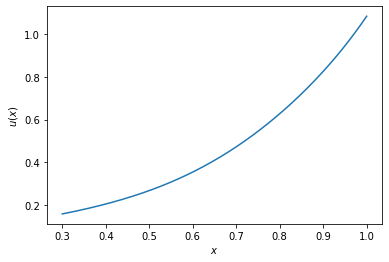

In [30]:
fig = plt.figure()
plt.plot(xx,yy)
plt.xlabel(r"$x$")
plt.ylabel(r"$u(x)$")
plt.show()

In [33]:
saver = tf.train.Saver()
sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver.save(sess, '/content/drive/MyDrive/Colab Notebooks/deep_surrogate/Biot/my-test-model')

'/content/drive/MyDrive/Colab Notebooks/deep_surrogate/Biot/my-test-model'